In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Roboto']})

mmsdm_directory = os.path.join(os.path.curdir, 'data', 'mmsdm')
scenarios_directory = os.path.join(os.path.curdir, 'data', 'scenarios')
output_directory = os.path.join(os.path.curdir, 'output')

price_filename = 'PUBLIC_DVD_DISPATCHPRICE_202011010000.CSV'
region_filename = 'PUBLIC_DVD_DISPATCHREGIONSUM_202011010000.CSV'
scada_filename = 'PUBLIC_DVD_DISPATCH_UNIT_SCADA_202011010000.CSV'
dudetail_filename = 'PUBLIC_DVD_DUDETAILSUMMARY_202011010000.CSV'
price_key = 'RRP'
region_id = 'SA1'
start = '20201117158'
end = '20201117180'
run_id = '1619451729'


def interval_to_datetime(interval):
    """Convert dispatch interval ID to datetime"""

    year = interval[:4]
    month = interval[4:6]
    day = interval[6:8]
    interval_id = interval[8:]

    # Start of trading day
    day_start = pd.to_datetime(f'{year}-{month}-{day} 4:00:00')

    # Offset since start of trading day
    offset = pd.Timedelta(minutes=5 * int(interval_id))

    # Interval timestamp
    timestamp = day_start + offset

    return timestamp


def load_run_results(data_dir, run_id):
    """Load results"""

    return pd.read_csv(os.path.join(data_dir, f'{run_id}.csv'))


def load_dispatch_prices(data_dir, filename):
    """Load historical dispatch prices"""

    df = pd.read_csv(os.path.join(data_dir, filename),
                     skiprows=1, skipfooter=1, engine='python')

    # Convert data types
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
    df['DISPATCHINTERVAL'] = df['DISPATCHINTERVAL'].astype(str)

    # Check for duplicates
    assert not df[['SETTLEMENTDATE', 'REGIONID']
                  ].duplicated().any(), 'Duplicates found in time index'

    return df


def load_dispatch_region(data_dir, filename):
    """Load dispatch region summary"""

    df = pd.read_csv(os.path.join(data_dir, filename),
                     skiprows=1, skipfooter=1, engine='python')

    # Convert data types
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
    df['DISPATCHINTERVAL'] = df['DISPATCHINTERVAL'].astype(str)

    # Check for duplicates
    assert not df[['SETTLEMENTDATE', 'REGIONID']
                  ].duplicated().any(), 'Duplicates found in time index'

    return df


def get_price_data(data_dir, filename, region_id, price_key, start, end):
    """Get price series"""

    # Load dataset
    df = load_dispatch_prices(data_dir=data_dir, filename=filename)

    # Filter dataset
    columns = ['SETTLEMENTDATE', 'REGIONID',
               'INTERVENTION', price_key, 'DISPATCHINTERVAL']
    df = df.loc[df['REGIONID'] == region_id, columns]
    mask = (df['DISPATCHINTERVAL'] >= start) & (df['DISPATCHINTERVAL'] <= end)
    filtered = df.loc[mask, :]

    return filtered['SETTLEMENTDATE'], filtered[price_key]


def get_heatmap_data(data_dir, run_id):
    """Format data used to plot heatmap"""

    df = load_run_results(data_dir=data_dir, run_id=run_id)
    df['timestamp'] = df['case_id'].apply(
        lambda x: interval_to_datetime(str(x)).to_pydatetime())

    df = df.pivot(index='SA1-DF', columns='timestamp',
                  values='SA1-EnergyPrice')
    df = df.sort_index(ascending=True)

    return df


def get_region_data(data_dir, filename, region_id, key, start, end):
    """Get demand forecast data for a given region and window"""

    df = load_dispatch_region(data_dir=data_dir, filename=filename)

    mask = (df['DISPATCHINTERVAL'] >= start) & (
        df['DISPATCHINTERVAL'] <= end) & (df['REGIONID'] == region_id)

    filtered = df.loc[mask, :].sort_values(by='SETTLEMENTDATE')

    return filtered['SETTLEMENTDATE'].tolist(), filtered[key].tolist()


def get_dispatch_scada(data_dir, filename):
    """Load dispatch SCADA information"""

    # Load from CSV and drop last row
    df = pd.read_csv(os.path.join(mmsdm_directory, scada_filename), skiprows=1)
    df = df.iloc[:-1]

    # Convert to datetime
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])

    return df


def get_dudetail(data_dir, filename):
    """Load DUID information"""

    df = pd.read_csv(os.path.join(mmsdm_directory, dudetail_filename),
                     skiprows=1, skipfooter=1, engine='python')
    df = df.sort_values(by=['DUID', 'END_DATE'])

    # Mapping between DUIDs and regions
    output = df.drop_duplicates(subset=['DUID'], keep='last').set_index('DUID')[
        ['REGIONID', 'DISPATCHTYPE']]

    return output

# Price volatility

## Overview
Over the span of two hours on 17 November 2020 South Australian dispatch prices increased from 45 $/MWh to over 250 $/MWh before falling to 62 $/MWh. The following analysis uses the NEMDE API to explore the underlying factors responsible for this price volatility.

## Analysis
Dispatch prices for the period under investigation are shown in Figure 1. When examining the historical price series from 5.10pm to 5.45pm there appears be no indication that South Australian dispatch prices are on the verge of experiencing significant volatility over the following hour. Were the price movements from 5.50pm to 6.45pm due to a contingency event, or were there changes occurring to system dynamics in the lead up to 5.50pm that only began to be reflected in prices at 5.55pm? Sensitivity analyses can assist in answering these questions by estimating the prices that would be realised under different operating scenarios.

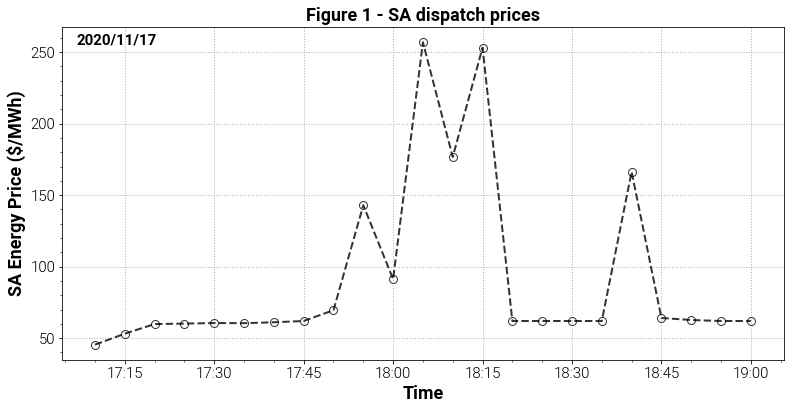

In [2]:
def plot_price_series(data_dir, output_dir, filename, region_id, price_key, start, end):
    """Plot prices"""

    fig, ax = plt.subplots()
    x, y = get_price_data(data_dir=data_dir, filename=filename,
                          region_id=region_id, price_key=price_key, start=start, end=end)

    ax.plot(x, y, linestyle='--', color='k', marker='o', alpha=0.8,
            markersize=8, linewidth=2, fillstyle='none')
    ax.grid(linestyle=':', linewidth=1)

    ax.xaxis.set_minor_locator(md.MinuteLocator(byminute=range(0, 60, 5)))
    ax.xaxis.set_major_locator(md.MinuteLocator(byminute=[0, 15, 30, 45]))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    ax.text(0.02, .98, '2020/11/17', transform=ax.transAxes, color='black',
            verticalalignment='top', fontsize=15, fontweight='bold')
    ax.set_title('Figure 1 - SA dispatch prices', fontweight='bold', fontsize=18)
    ax.set_xlabel('Time', fontweight='bold', fontsize=18)
    ax.set_ylabel('SA Energy Price ($/MWh)', fontweight='bold', fontsize=18)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    fig.set_size_inches(12, 6)
    fig.subplots_adjust(top=0.92, bottom=0.15, right=0.96)

    fig.savefig(os.path.join(output_dir, 'price-series.png'), dpi=900, transparent=True)

# Plot price series
plot_price_series(
    data_dir=mmsdm_directory,
    output_dir=output_directory,
    filename=price_filename,
    region_id='SA1',
    price_key='RRP',
    start=start,
    end=end
)

Understanding the relationship between demand and dispatch prices is particularly important as it can help exposit underlying dynamics relating to changes in the system's state. The NEMDE API is used to investigate this relationship by incrementally augmenting the Demand Forecast (DF) parameter for each dispatch interval and observing the resulting dispatch price. The DF parameter corresponds to the amount by which demand is expected to change over a dispatch interval. For example, a value of 10 MW denotes that demand is expected to be 10 MW higher at the end of a dispatch interval relative to the start of the interval. 

Scenarios are constructed by varying the DF parameter from -500MW to 500MW at 25 MW incremenets for each interval from 5.10pm to 7.00pm, with the results shown in Figure 2. Each dispatch interval is represented by a column comprised of rectangles. Each rectangle represents a demand forecast scenario, with the colour of the rectangle denoting the price observed for the scenario - lighter colours correspond to higher prices. These columns illustrate the relationship between demand and dispatch prices for each interval.

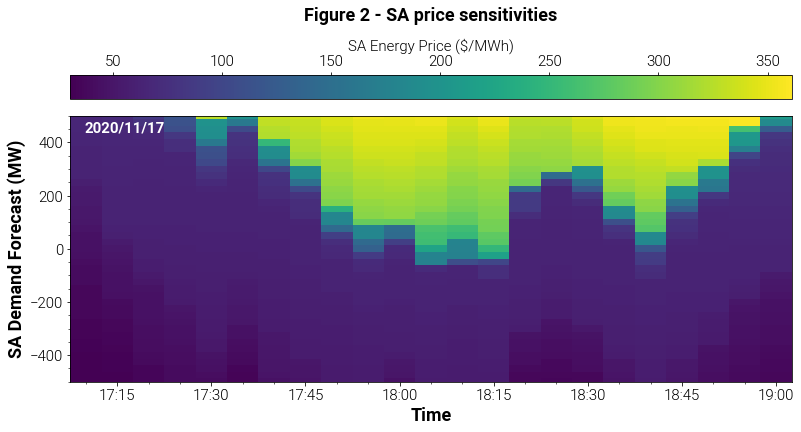

In [8]:
def plot_heatmap(data_dir, output_dir, run_id):
    """Plot heatmap"""

    # Get heatmap data
    df = get_heatmap_data(data_dir=data_dir, run_id=run_id)

    fig, ax = plt.subplots()
    im = ax.pcolormesh(*np.meshgrid(df.columns, df.index),
                       df, shading='nearest')
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal",
                        location='top', 
                        aspect=30)

    ax.xaxis.set_minor_locator(md.MinuteLocator(byminute=range(0, 60, 5)))
    ax.xaxis.set_major_locator(md.MinuteLocator(byminute=[0, 15, 30, 45]))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    ax.text(0.02, .98, '2020/11/17', transform=ax.transAxes, color='white',
            verticalalignment='top', fontsize=15, fontweight='bold')

    ax.set_xlabel('Time', fontweight='bold', fontsize=18)
    ax.set_ylabel('SA Demand Forecast (MW)', fontweight='bold', fontsize=18)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.set_ylim([-500, 500])

    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    fig.set_size_inches(12, 6)
    fig.subplots_adjust(top=0.92, bottom=0.15, right=0.96)

    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('SA Energy Price ($/MWh)', fontsize=15)

    fig.savefig(os.path.join(output_dir, 'heatmap-no-title.png'), dpi=300, transparent=True)
    
    ax.set_title('Figure 2 - SA price sensitivities', fontweight='bold', fontsize=18, pad=95)
    fig.savefig(os.path.join(output_dir, 'heatmap.png'), dpi=900, transparent=True)
    
    
# Plot heatmap
plot_heatmap(data_dir=scenarios_directory, output_dir=output_directory, run_id=run_id)

Overlaying the historical price series and realised demand forecast values in Figure 3 we can see how these price sensitivities change over the window under investigation. From 5.10pm to 6.05pm there is a downward shift in lighter coloured rectangles - the system is moving closer to a region where higher prices are likely to be observed. The DF parameter is typically in the order of 10's of MW, as shown by the red curve which denotes historical DF parameters observed for each interval. The intersection of the historical DF curve and colour of the rectangle it passes through corresponds to the historical price observed for that dispatch interval. The red curve begins in a dark blue rectangle indicating a relatively low price, but then intersects lighter coloured rectangles during the period of price volatility. By running scenarios over a wide range of demand forecast parameters we are forewarned of the price increase as we can see the lighter coloured rectangles approaching the red curve from 5.10pm to 5.55pm.

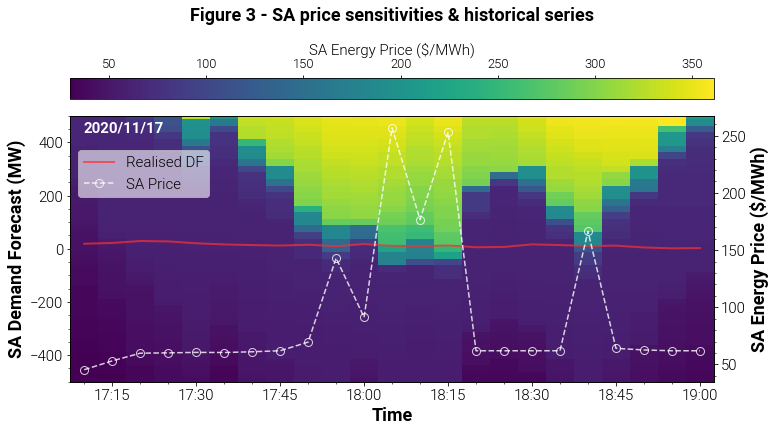

In [4]:
def plot_heatamp_price_series(mmsdm_dir, scenarios_dir, output_dir, price_filename, region_filename, region_id, price_key, start, end, run_id, plot_demand_forecast=False):
    """Plot heatmap and historical price series"""

    # Get data for heatmap plot and price series plot
    df = get_heatmap_data(data_dir=scenarios_dir, run_id=run_id)

    x2, y2 = get_price_data(
        data_dir=mmsdm_dir, filename=price_filename, region_id=region_id, price_key=price_key, start=start, end=end)

    x3, y3 = get_region_data(
        data_dir=mmsdm_dir, filename=region_filename, region_id='SA1', key='DEMANDFORECAST', start=start, end=end)

    # Initialise figure
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax2.zorder = 20
    ax1.zorder = 10

    # Plot heatmap
    im = ax1.pcolormesh(*np.meshgrid(df.columns, df.index), df, shading='nearest')

    # Plot demand forecast
    if plot_demand_forecast:
        line1 = ax1.plot(x3, y3, color='#ff3030', alpha=0.7,
                         linewidth=2, linestyle='-', label='Realised DF')

    # Plot price series
    line2 = ax2.plot(x2, y2, linestyle='--', color='w', marker='o', alpha=0.8,
                     markersize=8, linewidth=1.5, fillstyle='none', label='SA Price',
                     markeredgewidth=1)

    # Format heatmap plot
    ax1.set_ylim(-500, 500)
    ax1.xaxis.set_minor_locator(md.MinuteLocator(byminute=range(0, 60, 5)))
    ax1.xaxis.set_major_locator(md.MinuteLocator(byminute=[0, 15, 30, 45]))
    ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(10))

    # Format price series
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(50))

    ax1.set_facecolor("none")
    ax2.set_facecolor("none")
    
    ax1.set_title('Figure 3 - SA price sensitivities & historical series', fontweight='bold', fontsize=18, pad=95)

    ax1.set_xlabel('Time', fontweight='bold', fontsize=18)
    ax2.set_ylabel('SA Energy Price ($/MWh)', fontweight='bold', fontsize=18)
    ax1.set_ylabel('SA Demand Forecast (MW)', fontweight='bold', fontsize=18)
    ax1.xaxis.set_tick_params(labelsize=15)
    ax1.yaxis.set_tick_params(labelsize=15)
    ax2.yaxis.set_tick_params(labelsize=15)

    cbar = fig.colorbar(im, ax=ax2, pad=0.05, orientation='horizontal', location='top', aspect=30)
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('SA Energy Price ($/MWh)', fontsize=15)

    ax1.text(0.02, .98, '2020/11/17', transform=ax1.transAxes,
             color='white', verticalalignment='top', fontsize=15, fontweight='bold')

    if plot_demand_forecast:
        lns = line1 + line2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc=2, fontsize=15, bbox_to_anchor=(0, 0.9), framealpha=0.6)
        filename = 'heatmap-series-df'
    else:
        filename = 'heatmap-series'

    fig.set_size_inches(12, 6)
    fig.subplots_adjust(top=0.92, bottom=0.15, right=0.87)

    fig.savefig(os.path.join(output_dir, f'{filename}.png'), dpi=900, transparent=True)


# Plot price series + heatmap
plot_heatamp_price_series(
    mmsdm_dir=mmsdm_directory,
    scenarios_dir=scenarios_directory,
    output_dir=output_directory,
    price_filename=price_filename,
    region_filename=region_filename,
    region_id=region_id,
    price_key=price_key,
    start=start,
    end=end,
    run_id=run_id,
    plot_demand_forecast=True
)

The price dynamics observed between 5.10pm and 5.55pm are analogous to walking near the edge of a cliff - the ground is flat until reaching the precipice. Similarly, prices remain relatively steady until reaching a critical level at which point they quickly increase. If we simply look at a historical prices we are walking with our eyes closed. By running scenarios with different DF parameters we are able to see our surroundings, in particular the location of the cliff's edge.

Attention now turns to identifying drivers of the price volatility observed from 5.55pm to 6.45pm. Examining demand and supply over the window under investigation is a natural starting point. The amount by which demand and semi-scheduled output change over the window under investigation is shown in Figure 4. Plotted values denote the change observed relative to 5.10pm. Demand is approximatley 300 MW higher at the end of the window relative to the start, while semi-scheduled output has fallen by a similar amount. For reference, total demand in South Australia is 1086 MW at 5.10pm.  This rapid increase in demand coupled with a reduction in supply results in a move up the supply curve, illustrated by the downward movement of yellow and green rectangles from 5.10pm to 6.05pm in Figure 3.

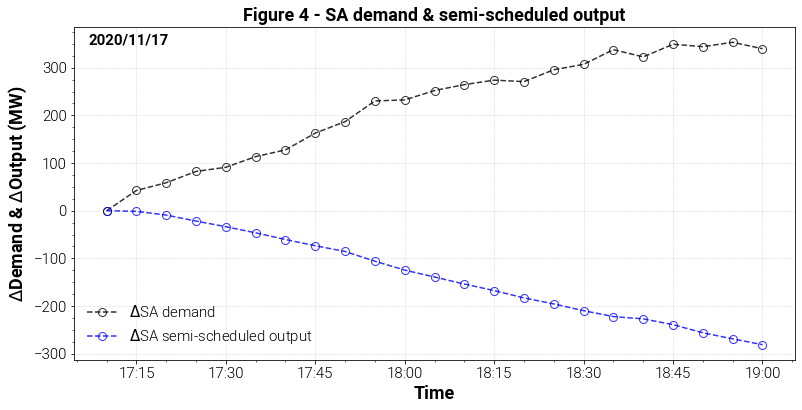

In [5]:
def plot_demand_semi_scheduled(data_dir, output_dir, filename, region_id, start, end):
    """Plot change in demand and semi-scheduled generation over the dispatch interval"""

    x1, y1 = get_region_data(data_dir=data_dir, filename=filename, region_id=region_id, key='TOTALDEMAND', start=start, end=end)
    y1_plot = [i - y1[0] for i in y1]

    x2, y2 = get_region_data(data_dir=data_dir, filename=filename, region_id=region_id, key='SEMISCHEDULE_CLEAREDMW', start=start, end=end)
    y2_plot = [i - y2[0] for i in y2]

    fig, ax = plt.subplots()

    ax.plot(x1, y1_plot, linestyle='--', color='k', marker='o', alpha=0.8,
            markersize=8, linewidth=1.5, fillstyle='none', label='$\Delta$SA demand')
    ax.plot(x2, y2_plot, linestyle='--', color='b', marker='o', alpha=0.8,
            markersize=8, linewidth=1.5, fillstyle='none', label='$\Delta$SA semi-scheduled output')

    ax.grid(linestyle=':', linewidth=0.5)

    ax.xaxis.set_minor_locator(md.MinuteLocator(byminute=range(0, 60, 5)))
    ax.xaxis.set_major_locator(md.MinuteLocator(byminute=[0, 15, 30, 45]))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    ax.text(0.02, .98, '2020/11/17', transform=ax.transAxes, color='black',
            verticalalignment='top', fontsize=15, fontweight='bold')
    
    ax.set_title('Figure 4 - SA demand & semi-scheduled output', fontweight='bold', fontsize=18)
    ax.set_xlabel('Time', fontweight='bold', fontsize=18)
    ax.set_ylabel('$\Delta$Demand & $\Delta$Output (MW)', fontweight='bold', fontsize=18)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))

    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    ax.legend(fontsize=15, loc='lower left', frameon=False)

    fig.set_size_inches(12, 6)
    fig.subplots_adjust(top=0.92, bottom=0.15, right=0.96)

    fig.savefig(os.path.join(output_dir, 'demand-semi-scheduled.png'), dpi=900, transparent=True)
    fig.savefig(os.path.join(output_dir, 'demand-semi-scheduled.pdf'), transparent=True)


plot_demand_semi_scheduled(
    data_dir=mmsdm_directory,
    output_dir=output_directory,
    filename=region_filename,
    region_id=region_id,
    start=start,
    end=end
)

Net generation and demand relative to the start of the window under investigation can also be compared, with Figure 5 showing regional demand outpacing net generation.

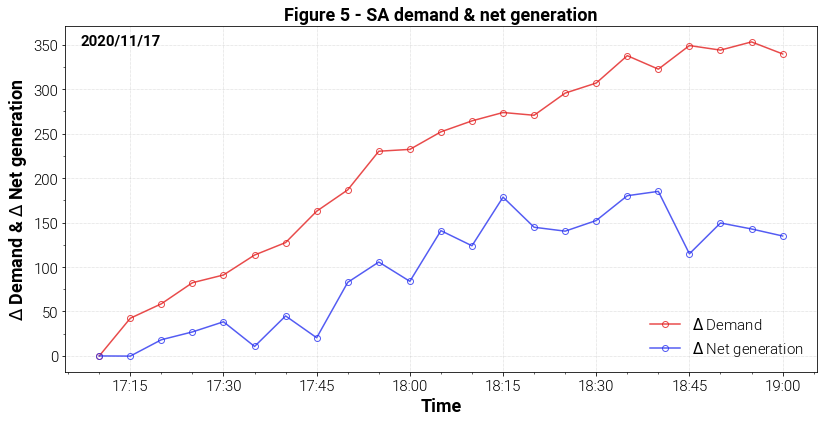

In [6]:
def get_duid_output(data_dir, scada_filename, dudetail_filename, region_id, dispatch_type, start, end):
    """"Get generator output"""

    scada = get_dispatch_scada(data_dir=mmsdm_directory, filename=scada_filename)
    details = get_dudetail(data_dir=mmsdm_directory, filename=dudetail_filename)

    # Filter SCADA data timestamps before merging with DUDETAIL frame
    timestamp_mask = ((scada['SETTLEMENTDATE'] >= interval_to_datetime(interval=start))
                      & (scada['SETTLEMENTDATE'] <= interval_to_datetime(interval=end)))
    scada = scada.loc[timestamp_mask, :]

    # Add region mapping
    df = pd.merge(scada, details, left_on='DUID', right_index=True)

    mask = (df['REGIONID'] == region_id) & (df['DISPATCHTYPE'] == dispatch_type)

    return df.loc[mask, :]


def get_delta_mw(data_dir, scada_filename, dudetail_filename, region_id, dispatch_type, start, end):
    """Compute difference in output relative to start of window"""

    df = get_duid_output(
        data_dir=data_dir,
        scada_filename=scada_filename,
        dudetail_filename=dudetail_filename,
        region_id=region_id,
        dispatch_type=dispatch_type,
        start=start,
        end=end)

    df = df.pivot(index='SETTLEMENTDATE', columns='DUID', values='SCADAVALUE')

    return df.subtract(df.iloc[0])


def get_total_delta_mw(data_dir, scada_filename, dudetail_filename, region_id, dispatch_type, start, end):
    """Get total Delta MW"""

    df = get_delta_mw(
        data_dir=data_dir,
        scada_filename=scada_filename,
        dudetail_filename=dudetail_filename,
        region_id=region_id,
        dispatch_type=dispatch_type,
        start=start,
        end=end)

    return df.sum(axis=1)


def get_total_net_delta_mw(data_dir, scada_filename, dudetail_filename, region_id, start, end):
    """Total delta MW from generators = Total delta MW from loads"""

    generation = get_total_delta_mw(
        data_dir=data_dir,
        scada_filename=scada_filename,
        dudetail_filename=dudetail_filename,
        region_id=region_id,
        dispatch_type='GENERATOR',
        start=start,
        end=end)

    load = get_total_delta_mw(
        data_dir=data_dir,
        scada_filename=scada_filename,
        dudetail_filename=dudetail_filename,
        region_id=region_id,
        dispatch_type='LOAD',
        start=start,
        end=end)

    return generation - load


def plot_demand_delta_generation(data_dir, region_filename, scada_filename, dudetail_filename, region_id, start, end):
    """Demand and delta generation"""

    x1, y1 = get_region_data(
        data_dir=data_dir,
        filename=region_filename,
        region_id=region_id,
        key='TOTALDEMAND',
        start=start,
        end=end)

    # Compute difference relative to start of interval
    y1_plot = [i - y1[0] for i in y1]

    delta_mw = get_total_net_delta_mw(
        data_dir=data_dir,
        scada_filename=scada_filename,
        dudetail_filename=dudetail_filename,
        region_id=region_id,
        start=start,
        end=end)

    fig, ax = plt.subplots()
    ax.plot(x1, y1_plot, color='#e31e1e', linewidth=1.5, alpha=0.8, label='$\Delta$ Demand', marker='o', fillstyle='none')
    ax.plot(delta_mw.index, delta_mw.values, color='#2933f0',
            linewidth=1.5, alpha=0.8, label='$\Delta$ Net generation', marker='o', fillstyle='none')

    ax.xaxis.set_minor_locator(md.MinuteLocator(byminute=range(0, 60, 5)))
    ax.xaxis.set_major_locator(md.MinuteLocator(byminute=[0, 15, 30, 45]))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    # Legend + text
    ax.legend(loc='lower right', fontsize=15, frameon=False)
    timestamp = interval_to_datetime(interval=start)
    ax.text(0.02, .98, timestamp.strftime('%Y/%m/%d'),
            transform=ax.transAxes, color='black',
            verticalalignment='top', fontsize=15, fontweight='bold')

    ax.set_title('Figure 5 - SA demand & net generation', fontweight='bold', fontsize=18)
    ax.set_ylabel('$\Delta$ Demand & $\Delta$ Net generation', fontsize=18, fontweight='bold')
    ax.set_xlabel('Time', fontsize=18, fontweight='bold')

    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))

    ax.grid(linestyle=':', linewidth=0.5)

    fig.subplots_adjust(right=0.97, bottom=0.14, top=0.94, left=0.10, wspace=0.05)
    fig.set_size_inches(12, 6)


plot_demand_delta_generation(
    data_dir=mmsdm_directory,
    region_filename=region_filename,
    scada_filename=scada_filename,
    dudetail_filename=dudetail_filename,
    region_id=region_id,
    start=start,
    end=end)

The following animation illustrates how prices become more sensitive to changes in demand before price volatility materialises. At 5.55pm demand intersects within a steep section of the supply curve, resulting in a sudden price increase. Note the supply curve has been constructed using the same information found in Figure 3.

![supply curve](supply-curve.gif)

Gradual shifts in the supply curve from 5.10pm to 5.55pm, coupled with the rapid increase in demand and reduction in output from semi-scheduled plant provides preliminary evidence suggesting demand and supply dynamics are the primary drivers of the price volatility observed. The impact of interconnector capabilities, generator availabilities, and generic constraints on South Australian dispatch prices could also be assessed, but is beyond the scope of this analysis.

## Summary
The NEMDE API allows otherwise unobservable relationships between system parameters and dispatch outcomes to be investigated. While this analysis has examined how changes to demand in South Australia affect dispatch prices in the same region, the NEMDE API can also be used to explore how other parameters such as interconnector capabilities, generator availabilities, or output from wind and solar plant impact dispatch outcomes.